In [166]:
import pandas as pd
import numpy as np
import ast
from fuzzywuzzy import fuzz
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

Load Data

In [167]:
# Load filtered labels (US/CA only)
labels_df = pd.read_csv('../output_data/weighted_algorithm_labels.csv')
print(f"Filtered labels: {len(labels_df)} records")

# Load Yelp dataset
print("\nLoading processed_yelp.csv...")
yelp_df = pd.read_csv('../input_data/processed_yelp.csv')
print(f"Yelp records: {len(yelp_df)} records")

# Parse list columns
def parse_list_string(x):
    if pd.isna(x) or x == '' or x == 'nan':
        return []
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x)
    except:
        return []

# Categories not needed for validation
# labels_df['categories_list'] = labels_df['categories_list'].apply(parse_list_string)
# labels_df['base_categories_list'] = labels_df['base_categories_list'].apply(parse_list_string)
# yelp_df['categories_list'] = yelp_df['categories_list'].apply(parse_list_string)

print("\n✓ Data loaded successfully")
labels_df.head(3)

Filtered labels: 2000 records

Loading processed_yelp.csv...
Yelp records: 150346 records

✓ Data loaded successfully
Yelp records: 150346 records

✓ Data loaded successfully


,sample_idx,id,base_id,name_primary,base_name_primary,names,base_names,categories_list,base_categories_list,categories,...,quality_diff_socials,label_socials,quality_score_brand_base,quality_score_brand,quality_diff_brand,label_brand,label_overall,quality_score_a,quality_score_b,quality_difference
0,0,08f44f055a9a016e0390f050aa3c93c0,1688849865669487,Goin' Postal Jacksonville,Goin' Postal Jacksonville,"{'primary': ""Goin' Postal Jacksonville""}","{'primary': ""Goin' Postal Jacksonville""}","['shipping_center', 'freight_and_cargo_service...","['vehicle_shipping', 'courier_and_delivery_ser...","{'primary': 'shipping_center', 'alternate': ['...",...,0.0,0.0,0.8,0.0,0.8,1.0,1.0,0.44,0.40,0.04
1,1,08f29a456e42e5830324637954145c50,1125899907111860,Valley Transmission,Valley Transmission,{'primary': 'Valley Transmission'},{'primary': 'Valley Transmission'},"['automotive_repair', 'automotive', 'professio...","['transmission_repair', 'automotive']","{'primary': 'automotive_repair', 'alternate': ...",...,0.0,0.0,0.8,0.0,0.8,1.0,1.0,0.44,0.41,0.03
2,2,08fbcd0030da5323031bcafa8c2fa0dc,844424934845986,Mazda Nelspruit,Mazda Nelspruit,{'primary': 'Mazda Nelspruit'},{'primary': 'Mazda Nelspruit'},"['car_dealer', 'automotive', 'automotive_dealer']","['used_car_dealer', 'automotive']","{'primary': 'car_dealer', 'alternate': ['autom...",...,0.0,0.0,0.8,0.0,0.8,1.0,1.0,0.39,0.34,0.05


## Matching Functions

High-quality matching with strict geographic constraints and multiple similarity metrics.

In [168]:
def name_similarity(name1, name2):
    """Calculate name similarity using fuzzy matching"""
    if not name1 or not name2 or pd.isna(name1) or pd.isna(name2):
        return 0.0
    return fuzz.token_sort_ratio(str(name1).lower(), str(name2).lower()) / 100.0

def address_similarity(addr1, addr2):
    """Calculate address similarity using fuzzy matching"""
    if not addr1 or not addr2 or pd.isna(addr1) or pd.isna(addr2):
        return 0.0
    return fuzz.token_sort_ratio(str(addr1).lower(), str(addr2).lower()) / 100.0

def category_jaccard(cats1, cats2):
    """Calculate category overlap using Jaccard similarity"""
    if not cats1 and not cats2:
        return 1.0  # Both empty = perfect match
    if not cats1 or not cats2:
        return 0.0  # One empty = no match
    
    # Normalize to lowercase for comparison
    set1 = set([str(c).lower() for c in cats1])
    set2 = set([str(c).lower() for c in cats2])
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    return intersection / union if union > 0 else 0.0

def find_best_yelp_match(sample_row, yelp_df, min_name_sim=0.6, min_combined_score=0.7):
    """
    Find best matching Yelp business for a sample using strict criteria
    
    Strategy:
    - MUST match city AND state exactly (strict geographic filter)
    - MUST have minimum name similarity (0.6)
    - MUST have minimum combined score (0.5)
    - Combined score = 0.5*name + 0.3*address + 0.2*categories
    
    Returns best match or None if no good match found
    """
    
    # Get sample attributes
    sample_city = str(sample_row.get('address_city', '')).lower().strip()
    sample_state = str(sample_row.get('address_state', '')).lower().strip()
    sample_name = sample_row['name_primary']
    sample_base_name = sample_row['base_name_primary']
    sample_address = sample_row['address_string']
    sample_base_address = sample_row['base_address_string']
    # Filter Yelp by exact city AND state match
    if not sample_city or not sample_state:
        return None
    
    yelp_candidates = yelp_df[
        (yelp_df['city'].str.lower().str.strip() == sample_city) &
        (yelp_df['state'].str.lower().str.strip() == sample_state)
    ]
    
    if len(yelp_candidates) == 0:
        return None
    
    best_match = None
    best_score = 0.0
    
    for idx, yelp_row in yelp_candidates.iterrows():
        yelp_name = yelp_row['name']
        yelp_address = yelp_row['address_string']
        
        # Calculate similarities for both sample sources
        name_sim = name_similarity(sample_name, yelp_name)
        base_name_sim = name_similarity(sample_base_name, yelp_name)
        
        addr_sim = address_similarity(sample_address, yelp_address)
        base_addr_sim = address_similarity(sample_base_address, yelp_address)
        
        
        # Use the BETTER of the two sources for matching
        best_name_sim = max(name_sim, base_name_sim)
        best_addr_sim = max(addr_sim, base_addr_sim)
        
        # Skip if name similarity too low
        if best_name_sim < min_name_sim:
            continue
        
        # Combined score with weights
        combined_score = (0.5 * best_name_sim + 
                         0.5 * best_addr_sim)
        
        if combined_score > best_score and combined_score >= min_combined_score:
            best_score = combined_score
            best_match = {
                'yelp_business_id': yelp_row['business_id'],
                'yelp_name': yelp_name,
                'yelp_address': yelp_address,
                'yelp_city': yelp_row['city'],
                'yelp_state': yelp_row['state'],
                'name_sim': name_sim,
                'base_name_sim': base_name_sim,
                'addr_sim': addr_sim,
                'base_addr_sim': base_addr_sim,
                'combined_score': combined_score
            }
    
    return best_match

print("✓ Matching functions defined")

✓ Matching functions defined


## 3. Match Records to Yelp

In [169]:
start_time = time.time()

matches = []
match_count = 0
no_match_count = 0

for idx, row in labels_df.iterrows():
    if idx % 100 == 0:
        print(f"  Processing {idx}/{len(labels_df)}...")
    
    match = find_best_yelp_match(row, yelp_df)
    
    if match:
        match['sample_idx'] = row['sample_idx']
        matches.append(match)
        match_count += 1
    else:
        no_match_count += 1

matches_df = pd.DataFrame(matches)

elapsed = time.time() - start_time
print(f"\n✓ Matching complete in {elapsed:.1f} seconds")
print(f"\nMatching Results:")
print(f"  Records with good Yelp matches: {match_count} ({match_count/len(labels_df)*100:.1f}%)")
print(f"  Records with no match: {no_match_count} ({no_match_count/len(labels_df)*100:.1f}%)")

if len(matches_df) > 0:
    print(f"\nMatch Quality:")
    print(f"  Mean combined score: {matches_df['combined_score'].mean():.3f}")
    print(f"  Median combined score: {matches_df['combined_score'].median():.3f}")
    print(f"  Min combined score: {matches_df['combined_score'].min():.3f}")
    print(f"  Max combined score: {matches_df['combined_score'].max():.3f}")
    
    high_quality = (matches_df['combined_score'] >= 0.7).sum()
    print(f"  High quality matches (≥0.7): {high_quality} ({high_quality/len(matches_df)*100:.1f}%)")

  Processing 0/2000...
  Processing 100/2000...
  Processing 100/2000...
  Processing 200/2000...
  Processing 200/2000...
  Processing 300/2000...
  Processing 300/2000...
  Processing 400/2000...
  Processing 400/2000...
  Processing 500/2000...
  Processing 500/2000...
  Processing 600/2000...
  Processing 600/2000...
  Processing 700/2000...
  Processing 700/2000...
  Processing 800/2000...
  Processing 800/2000...
  Processing 900/2000...
  Processing 900/2000...
  Processing 1000/2000...
  Processing 1000/2000...
  Processing 1100/2000...
  Processing 1100/2000...
  Processing 1200/2000...
  Processing 1200/2000...
  Processing 1300/2000...
  Processing 1300/2000...
  Processing 1400/2000...
  Processing 1400/2000...
  Processing 1500/2000...
  Processing 1500/2000...
  Processing 1600/2000...
  Processing 1600/2000...
  Processing 1700/2000...
  Processing 1700/2000...
  Processing 1800/2000...
  Processing 1800/2000...
  Processing 1900/2000...
  Processing 1900/2000...

✓ Matc

## Merge matched records with original labels and determine which source is closer to Yelp.

In [180]:
# Merge matches with labels
validation_df = labels_df.merge(matches_df, on='sample_idx', how='inner')

print(f"Validation dataset: {len(validation_df)} records")

def determine_better_source(base_score, non_base_score, threshold=0.05):
    """
    Determine which source is better based on similarity scores
    
    Returns:
        1 if base is better
        0 if non-base is better
        2 if tie (scores are very close)
    """
    diff = base_score - non_base_score
    
    if abs(diff) <= threshold:
        return 2  # Tie
    elif diff > 0:
        return 1  # Base is better
    else:
        return 0  # Non-base is better

# Generate ground truth labels based on Yelp comparison
validation_df['yelp_truth_names'] = validation_df.apply(
    lambda row: determine_better_source(row['base_name_sim'], row['name_sim']),
    axis=1
)
validation_df['yelp_truth_addresses'] = validation_df.apply(
    lambda row: determine_better_source(row['base_addr_sim'], row['addr_sim']),
    axis=1
)

print("\n✓ Ground truth labels generated")

Validation dataset: 36 records

✓ Ground truth labels generated


## 5. Calculate Validation Metrics

Compare weighted algorithm labels against Yelp-based ground truth.

In [171]:
def calculate_metrics(predicted, true, label_name):
    """Calculate accuracy and other metrics for label validation"""
    
    # Overall accuracy
    accuracy = accuracy_score(true, predicted)
    
    # Precision, recall, F1 for each class (0, 1, 2)
    precision, recall, f1, support = precision_recall_fscore_support(
        true, predicted, labels=[0, 1, 2], zero_division=0
    )
    
    # Confusion matrix
    cm = confusion_matrix(true, predicted, labels=[0, 1, 2])
    
    print(f"\n{'='*70}")
    print(f"VALIDATION METRICS: {label_name}")
    print(f"{'='*70}")
    print(f"Overall Accuracy: {accuracy:.3f}")
    print(f"\nPer-Class Metrics:")
    print(f"  Class 0 (Non-base better): Precision={precision[0]:.3f}, Recall={recall[0]:.3f}, F1={f1[0]:.3f}, Support={support[0]}")
    print(f"  Class 1 (Base better):     Precision={precision[1]:.3f}, Recall={recall[1]:.3f}, F1={f1[1]:.3f}, Support={support[1]}")
    print(f"  Class 2 (Tie):             Precision={precision[2]:.3f}, Recall={recall[2]:.3f}, F1={f1[2]:.3f}, Support={support[2]}")
    
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              0    1    2")
    print(f"True    0   {cm[0,0]:4d} {cm[0,1]:4d} {cm[0,2]:4d}")
    print(f"        1   {cm[1,0]:4d} {cm[1,1]:4d} {cm[1,2]:4d}")
    print(f"        2   {cm[2,0]:4d} {cm[2,1]:4d} {cm[2,2]:4d}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'confusion_matrix': cm
    }

# Validate each attribute type
names_metrics = calculate_metrics(
    validation_df['label_names'].fillna(2).astype(int),
    validation_df['yelp_truth_names'],
    'NAMES'
)

addresses_metrics = calculate_metrics(
    validation_df['label_addresses'].fillna(2).astype(int),
    validation_df['yelp_truth_addresses'],
    'ADDRESSES'
)


VALIDATION METRICS: NAMES
Overall Accuracy: 0.722

Per-Class Metrics:
  Class 0 (Non-base better): Precision=0.000, Recall=0.000, F1=0.000, Support=2
  Class 1 (Base better):     Precision=0.000, Recall=0.000, F1=0.000, Support=8
  Class 2 (Tie):             Precision=0.743, Recall=1.000, F1=0.852, Support=26

Confusion Matrix:
                Predicted
              0    1    2
True    0      0    0    2
        1      1    0    7
        2      0    0   26

VALIDATION METRICS: ADDRESSES
Overall Accuracy: 0.806

Per-Class Metrics:
  Class 0 (Non-base better): Precision=0.667, Recall=0.286, F1=0.400, Support=7
  Class 1 (Base better):     Precision=0.857, Recall=1.000, F1=0.923, Support=12
  Class 2 (Tie):             Precision=0.789, Recall=0.882, F1=0.833, Support=17

Confusion Matrix:
                Predicted
              0    1    2
True    0      2    1    4
        1      0   12    0
        2      1    1   15


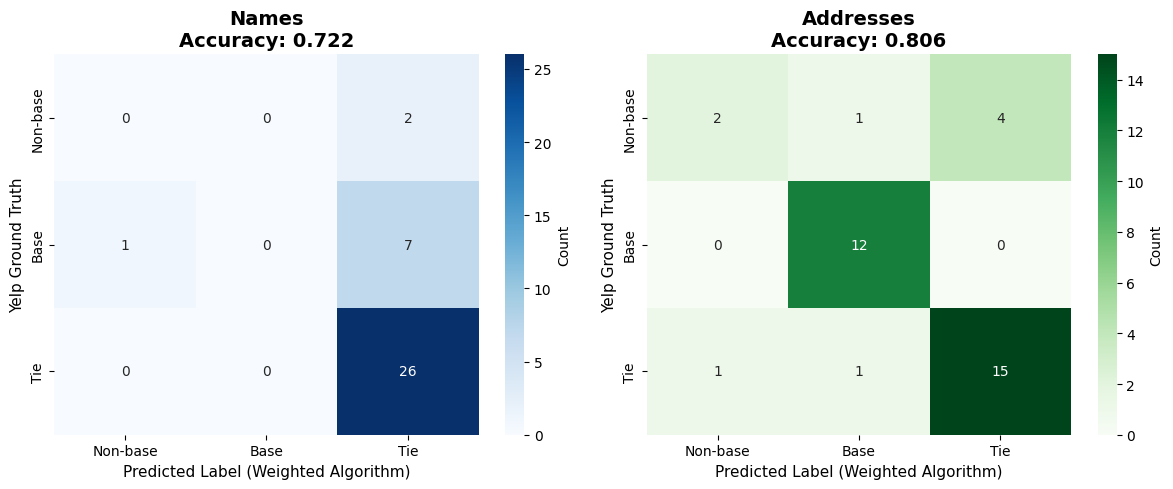


✓ Confusion matrices saved to output_data/validation_confusion_matrices.png


In [172]:
# Create confusion matrix heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Names confusion matrix
sns.heatmap(names_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-base', 'Base', 'Tie'],
            yticklabels=['Non-base', 'Base', 'Tie'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Names\nAccuracy: {names_metrics["accuracy"]:.3f}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label (Weighted Algorithm)', fontsize=11)
axes[0].set_ylabel('Yelp Ground Truth', fontsize=11)

# Addresses confusion matrix
sns.heatmap(addresses_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-base', 'Base', 'Tie'],
            yticklabels=['Non-base', 'Base', 'Tie'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Addresses\nAccuracy: {addresses_metrics["accuracy"]:.3f}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label (Weighted Algorithm)', fontsize=11)
axes[1].set_ylabel('Yelp Ground Truth', fontsize=11)

plt.tight_layout()
plt.savefig('../validation/v2/v2_validation_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved to output_data/validation_confusion_matrices.png")

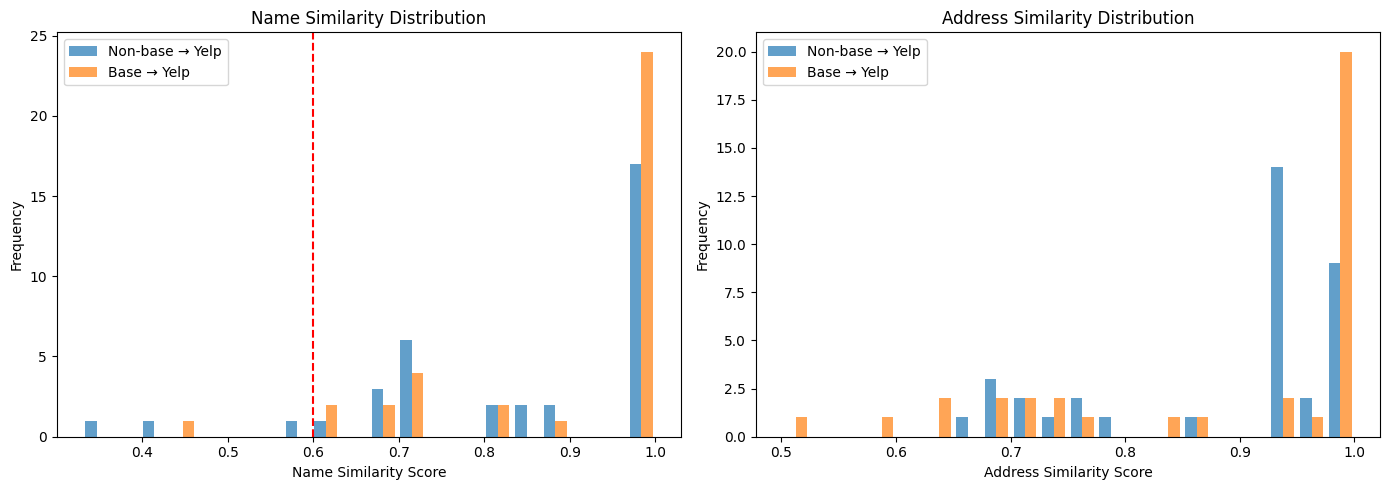

In [173]:
# Distribution of similarity scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Name similarities
axes[0].hist([validation_df['name_sim'], validation_df['base_name_sim']], 
                bins=20, label=['Non-base → Yelp', 'Base → Yelp'], alpha=0.7)
axes[0].set_xlabel('Name Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Name Similarity Distribution')
axes[0].legend()
axes[0].axvline(x=0.6, color='r', linestyle='--', label='Min threshold')

# Address similarities
axes[1].hist([validation_df['addr_sim'], validation_df['base_addr_sim']], 
                bins=20, label=['Non-base → Yelp', 'Base → Yelp'], alpha=0.7)
axes[1].set_xlabel('Address Similarity Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Address Similarity Distribution')
axes[1].legend()

plt.tight_layout()
plt.savefig('../validation/v2/v2_similarity_distributions.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Analyze Disagreements

Examine cases where weighted algorithm labels disagree with Yelp-based ground truth.

In [174]:
# Find disagreements for names
name_disagreements = validation_df[
    validation_df['label_names'].fillna(2).astype(int) != validation_df['yelp_truth_names']
]

print(f"Name Label Disagreements: {len(name_disagreements)} out of {len(validation_df)} ({len(name_disagreements)/len(validation_df)*100:.1f}%)")
print("\nSample disagreements:")
print("-" * 100)

for idx, row in name_disagreements.head(5).iterrows():
    print(f"\nSample {row['sample_idx']} (Combined score: {row['combined_score']:.3f}):")
    print(f"  Non-base name:    '{row['name_primary']}'")
    print(f"  Base name:        '{row['base_name_primary']}'")
    print(f"  Yelp name:        '{row['yelp_name']}'")
    print(f"  Non-base → Yelp similarity: {row['name_sim']:.3f}")
    print(f"  Base → Yelp similarity:     {row['base_name_sim']:.3f}")
    print(f"  Weighted algorithm label: {int(row['label_names'])} ({'Base' if row['label_names']==1 else 'Non-base' if row['label_names']==0 else 'Tie'})")
    print(f"  Yelp ground truth:        {int(row['yelp_truth_names'])} ({'Base' if row['yelp_truth_names']==1 else 'Non-base' if row['yelp_truth_names']==0 else 'Tie'})")

# Analyze address disagreements
print("\n" + "="*100)
addr_disagreements = validation_df[
    validation_df['label_addresses'].fillna(2).astype(int) != validation_df['yelp_truth_addresses']
]
print(f"\nAddress Label Disagreements: {len(addr_disagreements)} out of {len(validation_df)} ({len(addr_disagreements)/len(validation_df)*100:.1f}%)")

# Export disagreements to CSV files
print("\n" + "="*100)
print("EXPORTING DISAGREEMENTS")
print("="*100)

# Export name disagreements
name_disagreement_cols = [
    'sample_idx', 'id', 'base_id', 'yelp_business_id', 'combined_score',
    'name_primary', 'base_name_primary', 'yelp_name',
    'name_sim', 'base_name_sim',
    'label_names', 'yelp_truth_names',
    'quality_score_names', 'quality_score_names_base', 'quality_diff_names',
    'quality_score_a', 'quality_score_b', 'quality_difference'
]
name_disagreements[name_disagreement_cols].to_csv('../validation/v2/v2_name_disagreements.csv', index=False)
print(f"✓ Name disagreements exported: {len(name_disagreements)} records → output_data/name_disagreements.csv")

# Export address disagreements
addr_disagreement_cols = [
    'sample_idx', 'id', 'base_id', 'yelp_business_id', 'combined_score',
    'address_string', 'base_address_string', 'yelp_address',
    'addr_sim', 'base_addr_sim',
    'label_addresses', 'yelp_truth_addresses',
    'quality_score_addresses', 'quality_score_addresses_base', 'quality_diff_addresses',
    'quality_score_a', 'quality_score_b', 'quality_difference'
]
addr_disagreements[addr_disagreement_cols].to_csv('../validation/v2/v2_address_disagreements.csv', index=False)


Name Label Disagreements: 10 out of 36 (27.8%)

Sample disagreements:
----------------------------------------------------------------------------------------------------

Sample 76 (Combined score: 1.000):
  Non-base name:    'SKH Locksmiths & Security LLC'
  Base name:        'SKH Locksmiths'
  Yelp name:        'Skh Locksmiths'
  Non-base → Yelp similarity: 0.680
  Base → Yelp similarity:     1.000
  Weighted algorithm label: 2 (Tie)
  Yelp ground truth:        1 (Base)

Sample 128 (Combined score: 1.000):
  Non-base name:    'Miller's Ale House - Tampa Airport'
  Base name:        'Miller's Ale House'
  Yelp name:        'Miller's Ale House'
  Non-base → Yelp similarity: 0.720
  Base → Yelp similarity:     1.000
  Weighted algorithm label: 2 (Tie)
  Yelp ground truth:        1 (Base)

Sample 281 (Combined score: 1.000):
  Non-base name:    'Hollyhock Hill'
  Base name:        'Hollyhock Hill Restaurant'
  Yelp name:        'Hollyhock Hill'
  Non-base → Yelp similarity: 1.000
  Base

## 8. Summary and Insights

In [179]:
print("=" * 80)
print("VALIDATION SUMMARY")
print("=" * 80)
print(f"\nTotal labeled records: {len(labels_df)}")
print(f"Records with Yelp matches: {len(validation_df)} ({len(validation_df)/len(labels_df)*100:.1f}%)")
# Agreement rate
print(f"\nWeighted algorithm vs Yelp ground truth agreement:")
agreement_names = (validation_df['label_names'].fillna(2).astype(int) == validation_df['yelp_truth_names']).sum()
agreement_addr = (validation_df['label_addresses'].fillna(2).astype(int) == validation_df['yelp_truth_addresses']).sum()

print(f"   - Names: {agreement_names}/{len(validation_df)} agree ({agreement_names/len(validation_df)*100:.1f}%)")
print(f"   - Addresses: {agreement_addr}/{len(validation_df)} agree ({agreement_addr/len(validation_df)*100:.1f}%)")

print("\n" + "=" * 80)

VALIDATION SUMMARY

Total labeled records: 2000
Records with Yelp matches: 36 (1.8%)

Weighted algorithm vs Yelp ground truth agreement:
   - Names: 26/36 agree (72.2%)
   - Addresses: 29/36 agree (80.6%)



## 9. Export Validation Results

In [176]:
# Export validation results with comparison
export_cols = [
    'sample_idx', 'id', 'base_id', 'yelp_business_id', 'combined_score',
    'yelp_city', 'yelp_state',
    # Names
    'name_primary', 'base_name_primary', 'yelp_name',
    'name_sim', 'base_name_sim',
    'label_names', 'yelp_truth_names',
    'quality_score_names', 'quality_score_names_base', 'quality_diff_names',
    # Addresses  
    'address_string', 'base_address_string', 'yelp_address',
    'addr_sim', 'base_addr_sim',
    'label_addresses', 'yelp_truth_addresses',
    'quality_score_addresses', 'quality_score_addresses_base', 'quality_diff_addresses',
    # Overall quality scores
    'quality_score_a', 'quality_score_b', 'quality_difference'
]

validation_export = validation_df[export_cols].copy()
validation_export.to_csv('../validation/v2/v2_validation_results.csv', index=False)
